In [7]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
#from sklearn.calibration import CalibratedClassifierCV
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train_df_raw, val_df_raw = train_test_split(df, test_size=0.2, random_state=42)

def get_safe_survival_mapping(train_fs, test_fs):
    train_fs = train_fs.copy()
    test_fs = test_fs.copy()

    for df in [train_fs, test_fs]:
        df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
        df['Is_Adult_Male'] = df['Name'].str.contains('Mr\.').astype(int)
        
    train_fs['Family_Survival'] = 2
    test_fs['Family_Survival'] = 2

    for _, group in train_fs.groupby(['Surname', 'Fare']):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if row['Is_Adult_Male'] == 1:
                    train_fs.loc[ind, 'Family_Survival'] = 0
                else:
                    others = group.drop(ind)
                    if others['Survived'].max() == 1.0:
                        train_fs.loc[ind, 'Family_Survival'] = 1
                    elif others['Survived'].max() == 0.0:
                        train_fs.loc[ind, 'Family_Survival'] = 0
    for _, group in train_fs.groupby('Ticket'):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if train_fs.loc[ind, 'Family_Survival'] == 2:
                    if row['Is_Adult_Male'] == 1:
                        train_fs.loc[ind, 'Family_Survival'] = 0
                    else: 
                        others = group.drop(ind)
                        if others['Survived'].max() == 1.0:
                            train_fs.loc[ind, 'Family_Survival'] = 1
                        elif others['Survived'].max() == 0.0:
                            train_fs.loc[ind, 'Family_Survival'] = 0

    for ind, row in test_fs.iterrows():
        if row['Is_Adult_Male'] == 1:
            test_fs.loc[ind, 'Family_Survival'] = 0
            continue
        fam_in_train = train_fs[(train_fs['Surname'] == row['Surname']) & (train_fs['Fare'] == row['Fare'])]
        ticket_in_train = train_fs[train_fs['Ticket'] == row['Ticket']]

        combined = pd.concat([fam_in_train, ticket_in_train])

        if len(combined) > 0:
            if combined['Survived'].max() == 1.0:
                test_fs.loc[ind, 'Family_Survival'] = 1
            elif combined['Survived'].max() == 0.0:
                test_fs.loc[ind, 'Family_Survival'] = 0

    full_mapping = pd.concat([train_fs[['PassengerId', 'Family_Survival']],
                                    test_fs[['PassengerId', 'Family_Survival']]])
    return full_mapping

def fill_missing_fare(df):
    return df.groupby(['Pclass', 'Embarked'])['Fare_Individual'].transform(lambda x: x.fillna(x.median()))

def prepare_data(df_input, survival_mapping, stats_df=None):
    df = df_input.copy()
    
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    
    df['IsAlone'] = (df['FamilySize'] == 1).astype(float)
    df['IsMother'] = ((df['Sex'] == 1) & (df['Parch'] > 0) & (df['Age'] > 18)).astype(float)
    df['IsChild'] = (df['Age'] < 14).astype(float)
    df['Fare_Log'] = df['Fare'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    deck_mapping = {'B': 0.74, 'D': 0.75, 'E': 0.75, 'C': 0.59, 'A': 0.50, 'T': 0.50, 'F': 0.61, 'G': 0.40, 'M': 0.23}
    df['Deck_Score'] = df['Deck'].map(deck_mapping)
    
    source_df = stats_df if stats_df is not None else df
    if 'Survived' in source_df.columns:
        temp_source = source_df.copy()
        temp_source['Deck'] = temp_source['Cabin'].str[0].fillna('M')
        stats = temp_source.groupby(['Pclass', 'Deck'])['Survived'].mean().reset_index()
        stats.columns = ['Pclass', 'Deck', 'Group_Survival_Rate']
        df = df.merge(stats, on=['Pclass', 'Deck'], how='left')
    
    df['Group_Survival_Rate'] = df['Group_Survival_Rate'].fillna(df['Group_Survival_Rate'].median())
    
    df = df.merge(survival_mapping, on='PassengerId', how='left')
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].replace(['Rev', 'Dr'], 'Service')
    df['Title'] = df['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Lady', 'Countess', 'Dona'], 'Noble')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Officer')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Pclass_Deck']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    df = pd.get_dummies(df)
    
    return df.astype(float)

fs_map = get_safe_survival_mapping(train_df_raw, val_df_raw)

X_train = prepare_data(train_df_raw, fs_map).drop(columns=['Survived'])
y_train = train_df_raw['Survived']

X_val = prepare_data(val_df_raw, fs_map).drop(columns=['Survived'])
y_val = val_df_raw['Survived']

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    w1 = trial.suggest_float('weight_rf', 0.1, 1.0)
    w2 = trial.suggest_float('weight_xgb', 0.1, 1.0)
    
    rf_model = RandomForestClassifier(
        n_estimators=370, max_depth=6, min_samples_split=12, 
        min_samples_leaf=4, random_state=42
    )
    
    xgb_model = XGBClassifier(**xgb_params)
    
    ensemble = VotingClassifier(
        estimators=[('rf', rf_model), ('xgb', xgb_model)],
        voting='soft',
        weights=[w1, w2]
    )
    
    score = cross_val_score(ensemble, X_train, y_train, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

xgb_best_params = study.best_params.copy()
w_rf = xgb_best_params.pop('weight_rf')
w_xgb = xgb_best_params.pop('weight_xgb')
best_xgb = XGBClassifier(**study.best_params, random_state=42)
best_rf = RandomForestClassifier(n_estimators=370, max_depth=6, min_samples_split=12, min_samples_leaf=4, random_state=42)

#calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
#calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=5)

final_model = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    voting='soft',
    weights=[w_rf, w_xgb]
)
final_model.fit(X_train, y_train)
print("-" * 30)
print(f"Лучший CV результат: {study.best_value:.2%}")
print(f"Честная точность на валидации: {final_model.score(X_val, y_val):.2%}")
print("best_params = {")
for key, value in study.best_params.items():
    if isinstance(value, str):
        print(f"    '{key}': '{value}',")
    else:
        print(f"    '{key}': {value},")
print("    'random_state': 42")
print("}") 
print("-" * 30)

<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:22: SyntaxWarning: invalid escape sequence '\.'
C:\Users\user\AppData\Local\Temp\ipykernel_5704\1124896037.py:22: SyntaxWarning: invalid escape sequence '\.'
  df['Is_Adult_Male'] = df['Name'].str.contains('Mr\.').astype(int)
[I 2025-12-29 20:52:49,015] A new study created in memory with name: no-name-04c60205-e7dd-415f-b052-136fc323cc93
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:52:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:52:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:52:53] WARNING: C:\actions-runn

------------------------------
Лучший CV результат: 85.11%
Честная точность на валидации: 86.59%
best_params = {
    'n_estimators': 81,
    'max_depth': 9,
    'learning_rate': 0.012001421532509125,
    'subsample': 0.644995178490818,
    'colsample_bytree': 0.8939772723281512,
    'weight_rf': 0.9287494075741388,
    'weight_xgb': 0.660981206519559,
    'random_state': 42
}
------------------------------


d:\system\python\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:58:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "weight_rf", "weight_xgb" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Deck_T                 0.000000
Title_Noble            0.000000
Deck_G                 0.000000
Title_the Countess     0.000000
Deck_F                 0.000252
Title_Officer          0.000400
Deck_A                 0.000471
Deck_D                 0.000931
Embarked_Q             0.002091
Deck_C                 0.002401
Deck_B                 0.003364
Deck_E                 0.003880
Title_Master           0.004542
Title_Service          0.004863
Embarked_C             0.005881
IsAlone                0.005883
Embarked_S             0.010595
IsMother               0.011470
IsChild                0.013427
Deck_M                 0.018000
Has_Cabin              0.022575
Ticket_Group_Size      0.031814
FamilySize             0.032279
Deck_Score             0.034777
Age                    0.041132
Pclass                 0.041650
Fare                   0.046705
Title_Miss             0.047380
Family_Survival        0.054003
Fare_Log               0.056495
Group_Survival_Rate    0.065788
Title_Mr

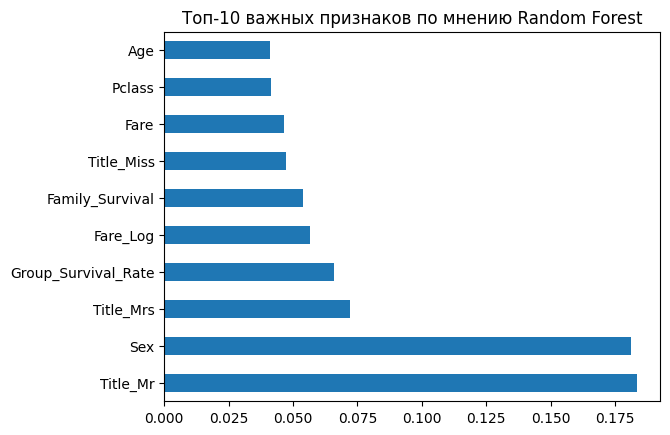

Text(50.722222222222214, 0.5, 'Actual')

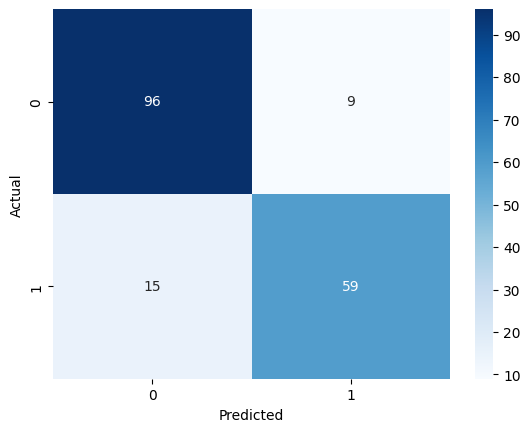

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
best_rf.fit(X_train, y_train)

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=True).head(40))
importances.nlargest(10).plot(kind='barh')
plt.title('Топ-10 важных признаков по мнению Random Forest')
plt.show()

errors_df = val_df_raw.copy()
errors_df['Actual'] = val_df_raw['Survived']
errors_df['Predicted'] = final_model.predict(X_val)
errors = errors_df[errors_df['Actual'] != errors_df['Predicted']]
errors.head(10)

y_probs = final_model.predict_proba(X_val)[:, 1]
y_pred_custom = (y_probs >= 0.5).astype(int)
sns.heatmap(confusion_matrix(y_val, y_pred_custom), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')